## Contents
- [Imports](#Imports)
- [Visualizing COVID Cases by State](#Visualizing-COVID-Cases-by-State)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Export Data for Modeling](#Export-Data-for-Modeling)

# Imports

In [16]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Import the overall state data.
df = pd.read_csv('../data/cleaned_numbers_five_states.csv')

# Import the state time series data.
df_time = pd.read_csv('../data/preprocessing/raw_covid_five_states_cases_time_series.csv')

In [18]:
# Display the first few rows of the dataframe.
df.head(2)

county_state  total_cases  total_fatalities  death_rate  \
0  Santa Clara County, California      23978.0             388.0    0.016181   
1    San Mateo County, California      10942.0             159.0    0.014531   

   total_tests     sq_mi  obes_percent  health_ins_noninst_pop  \
0       839764  1291.086         0.081                 1912773   
1       285657   448.636         0.071                  762101   

   health_ins_noninst_pop_cov_yes  health_ins_noninst_pop_cov_no  ...  \
0                         1821047                          91726  ...   
1                          725672                          36429  ...   

   sex_age_pop_55_to_59  sex_age_pop_60_to_64  sex_age_pop_65_to_74  \
0                120020                101578                138006   
1                 51530                 47435                 66210   

   sex_age_pop_75_to_84  sex_age_pop_85_and_over  sex_age_median_age_in_years  \
0                 75122                    33780                         37.0   
1                 33971                    17686                         39.6   

   deaths_per_100_cases  cases_per_100_people  tests_per_100_people  \
0              1.618150              1.247425             43.687650   
1              1.453116              1.428581             37.295201   

   pop_density  
0  1488.824137  
1  1707.252650  

[2 rows x 56 columns]

In [19]:
# Display the first few rows of the dataframe.
df_time.head(2)

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0

# Visualizing COVID Cases By State

### Use the time series dataframe to visualize COVID cases over time.

In [20]:
# Convert 'date' to a datetime object.
df_time['date'] = pd.to_datetime(df_time['date'])

In [21]:
# Set the date to the index.
df_time = df_time.set_index('date')

In [22]:
# Return the min index for each state.
print(df_time[df_time['state'].str.contains('California')].index.min())
print(df_time[df_time['state'].str.contains('Florida')].index.min())
print(df_time[df_time['state'].str.contains('Illinois')].index.min())
print(df_time[df_time['state'].str.contains('New York')].index.min())
print(df_time[df_time['state'].str.contains('Texas')].index.min())

2020-01-25 00:00:00
2020-03-01 00:00:00
2020-01-24 00:00:00
2020-03-01 00:00:00
2020-02-12 00:00:00


In [23]:
# Set the index of the data to the first date shared by all states.
df_time = df_time.loc['2020-03-01':]

In [24]:
# Extract California data to a dataframe.
df_time_ca = df_time[df_time['state'].str.contains('California')]

In [25]:
# Extract Florida data to a dataframe.
df_time_fl = df_time[df_time['state'].str.contains('Florida')]

In [26]:
# Extract Illinois data to a dataframe.
df_time_il = df_time[df_time['state'].str.contains('Illinois')]

In [27]:
# Extract New York data to a dataframe.
df_time_ny = df_time[df_time['state'].str.contains('New York')]

In [28]:
# Extract Texas data to a dataframe.
df_time_tx = df_time[df_time['state'].str.contains('Texas')]

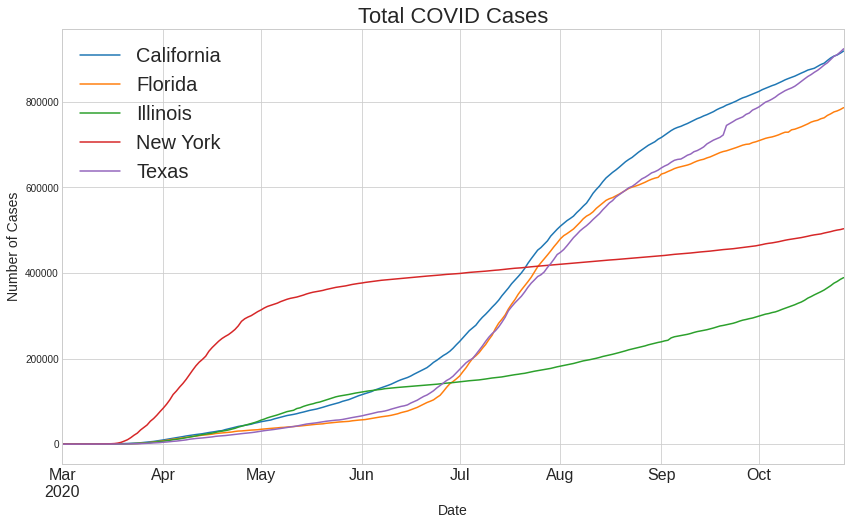

In [29]:
# Plot the total COVID cases by state.
plt.figure(figsize=(14,8))
df_time_ca['cases'].plot(label='California')
df_time_fl['cases'].plot(label='Florida')
df_time_il['cases'].plot(label='Illinois')
df_time_ny['cases'].plot(label='New York')
df_time_tx['cases'].plot(label='Texas')
plt.title('Total COVID Cases', fontsize=22)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks(fontsize=16)
plt.legend(fontsize=20);

# Feature Engineering

### Create a State Column

In [30]:
# Create a state column based on county_state.
df['state'] = pd.np.where(df['county_state'].str.contains('California'), 'California',
              pd.np.where(df['county_state'].str.contains('Florida'), 'Florida',
              pd.np.where(df['county_state'].str.contains('Illinois'), 'Illinois',
              pd.np.where(df['county_state'].str.contains('New York'), 'New York', 'Texas'))))

### Create a County Column

In [5]:
# Create a county column based on county_state.
df['county'] = df['county_state']

In [6]:
# Drop extraneous county words for graphing.
df['county'] = df['county'].str.replace(' County, California', '')

In [7]:
# Drop extraneous county words for graphing.
df['county'] = df['county'].str.replace(' County, Florida', '')

In [8]:
# Drop extraneous county words for graphing.
df['county'] = df['county'].str.replace(' County, Illinois', '')

In [9]:
# Drop extraneous county words for graphing.
df['county'] = df['county'].str.replace(' County, New York', '')

In [10]:
# Drop extraneous county words for graphing.
df['county'] = df['county'].str.replace(' County, Texas', '')

### Ordinal COVID Severity

##### Create an ordinal COVID severity column for classification modeling.

In [11]:
# Create a covid_severity column.
df['covid_severity'] = 0

In [12]:
# Create masks to assign covid_severity to one of three classes based on
# numer of cases per 100 people in the county.
mask1 = df['cases_per_100_people'] < 2
mask2 = (df['cases_per_100_people'] >= 2) & (df['cases_per_100_people'] < 3)
mask3 = df['cases_per_100_people'] >= 3

In [13]:
# Apply the mask for level 1 (low).
df['covid_severity'][mask1] = 1

In [14]:
# Apply the mask for level 2 (medium).
df['covid_severity'][mask2] = 2

In [15]:
# Apply the mask for level 3 (high).
df['covid_severity'][mask3] = 3

In [16]:
# Display the count of counties in each severity category.
df['covid_severity'].value_counts()

1    228
3    158
2    157
Name: covid_severity, dtype: int64

### Demographic Recombinations

In [17]:
# Create different income demographic features for testing.
df['inc_hhlds_less_than_25_000'] = df['inc_hhlds_less_than_10_000']\
                    + df['inc_hhlds_10_000_to_14_999'] + df['inc_hhlds_15_000_to_24_999']

df['inc_hhlds_25_000_to_49_999'] = df['inc_hhlds_25_000_to_34_999']\
                    + df['inc_hhlds_35_000_to_49_999']

df['inc_hhlds_less_than_99_999'] = df['inc_hhlds_less_than_10_000']\
                    + df['inc_hhlds_10_000_to_14_999'] + df['inc_hhlds_15_000_to_24_999']\
                    + df['inc_hhlds_25_000_to_34_999'] + df['inc_hhlds_35_000_to_49_999']\
                    + df['inc_hhlds_50_000_to_74_999'] + df['inc_hhlds_75_000_to_99_999']\

df['inc_hhlds_100_000_or_more'] = df['inc_hhlds_100_000_to_149_999']\
                    + df['inc_hhlds_150_000_to_199_999']

df['inc_hhlds_less_than_49_999'] = df['inc_hhlds_less_than_10_000']\
                    + df['inc_hhlds_10_000_to_14_999'] + df['inc_hhlds_15_000_to_24_999']\
                    + df['inc_hhlds_25_000_to_34_999'] + df['inc_hhlds_35_000_to_49_999']\

df['inc_hhlds_50_000_to_99_999'] = df['inc_hhlds_50_000_to_74_999'] + df['inc_hhlds_75_000_to_99_999']

df['inc_hhlds_100_000_or_more'] = df['inc_hhlds_100_000_to_149_999']\
                    + df['inc_hhlds_150_000_to_199_999']

In [18]:
# Create different race demographic features for testing.
df['race_pop_other'] = df['race_pop_american_indian_and_alaska_native_alone']\
                    + df['race_pop_native_hawaiian_and_other_pacific_islander_alone']\
                    + df['race_pop_some_other_race_alone'] + df['race_pop_two_or_more_races']

In [19]:
# Create different age demographic features for testing.
df['sex_age_pop_0_to_44'] = df['sex_age_pop_under_5'] + df['sex_age_pop_5_to_9']\
                    + df['sex_age_pop_10_to_14'] + df['sex_age_pop_15_to_19']\
                    + df['sex_age_pop_20_to_24'] + df['sex_age_pop_25_to_34']\
                    + df['sex_age_pop_35_to_44']

df['sex_age_pop_45_to_74'] = df['sex_age_pop_45_to_54'] + df['sex_age_pop_55_to_59']\
                    + df['sex_age_pop_60_to_64'] + df['sex_age_pop_65_to_74']

df['sex_age_pop_75_and_over'] = df['sex_age_pop_75_to_84'] + df['sex_age_pop_85_and_over']

df['sex_age_pop_0_to_64'] = df['sex_age_pop_under_5'] + df['sex_age_pop_5_to_9']\
                    + df['sex_age_pop_10_to_14'] + df['sex_age_pop_15_to_19']\
                    + df['sex_age_pop_20_to_24'] + df['sex_age_pop_25_to_34']\
                    + df['sex_age_pop_35_to_44'] + df['sex_age_pop_45_to_54']\
                    + df['sex_age_pop_55_to_59'] + df['sex_age_pop_60_to_64']

df['sex_age_pop_65_and_over'] = df['sex_age_pop_65_to_74'] + df['sex_age_pop_75_to_84']\
                    + df['sex_age_pop_85_and_over']

df['sex_age_pop_0_to_35'] = df['sex_age_pop_under_5'] + df['sex_age_pop_5_to_9']\
                    + df['sex_age_pop_10_to_14'] + df['sex_age_pop_15_to_19']\
                    + df['sex_age_pop_20_to_24'] + df['sex_age_pop_25_to_34']

df['sex_age_pop_35_to_59'] = df['sex_age_pop_35_to_44'] + df['sex_age_pop_45_to_54']\
                    + df['sex_age_pop_55_to_59']

df['sex_age_pop_60_to_84'] = df['sex_age_pop_60_to_64'] + df['sex_age_pop_65_to_74']\
                    + df['sex_age_pop_75_to_84']

In [20]:
# Define a function to create new columns with percentages.
def to_percentage(df):
    for column in df.columns:
        if column.startswith('race_pop_'):
            df['percent_' + column] = df[column] / df['race_pop']
        elif column.startswith('sex_age_pop_'):
            df['percent_' + column] = df[column] / df['sex_age_pop']            
        elif column.startswith('health_ins_noninst_pop_cov'):
            df['percent_' + column] = df[column] / df['health_ins_noninst_pop']
        elif column.startswith('inc_hhlds_'):
            df['percent_' + column] = df[column] / df['inc_hhlds']
    return

In [21]:
# Apply the function to the dataframe.
to_percentage(df)

# Exploratory Data Analysis

## Correlations

In [22]:
# Extract the columns with percentages, save to a new dataframe.
df_percent = df.filter(regex = 'percent', axis = 1)

In [23]:
# Other metrics from the original dataframe to carry over.
# These were not total counts and thus not calculated in percentage step.
df_temp = df[[
    'county_state',
    'total_cases',
    'total_fatalities',
    'death_rate',
    'total_tests',
    'sex_age_median_age_in_years', 
    'inc_med_hhld_inc_dol',
    'inc_mean_hhld_inc_dol',
    'inc_per_capita_inc_dol',
    'inc_med_earn_male_full_yr_workers_dol',
    'inc_med_earn_female_full_yr_workers_dol',
    'deaths_per_100_cases',
    'cases_per_100_people',
    'tests_per_100_people',
    'pop_density',
    'covid_severity'
]]

In [24]:
# Concatenate the two dataframes to get a complete feature set.
df_percent = pd.concat([df_temp, df_percent], axis=1)

### Correlations for 'cases_per_100_people'

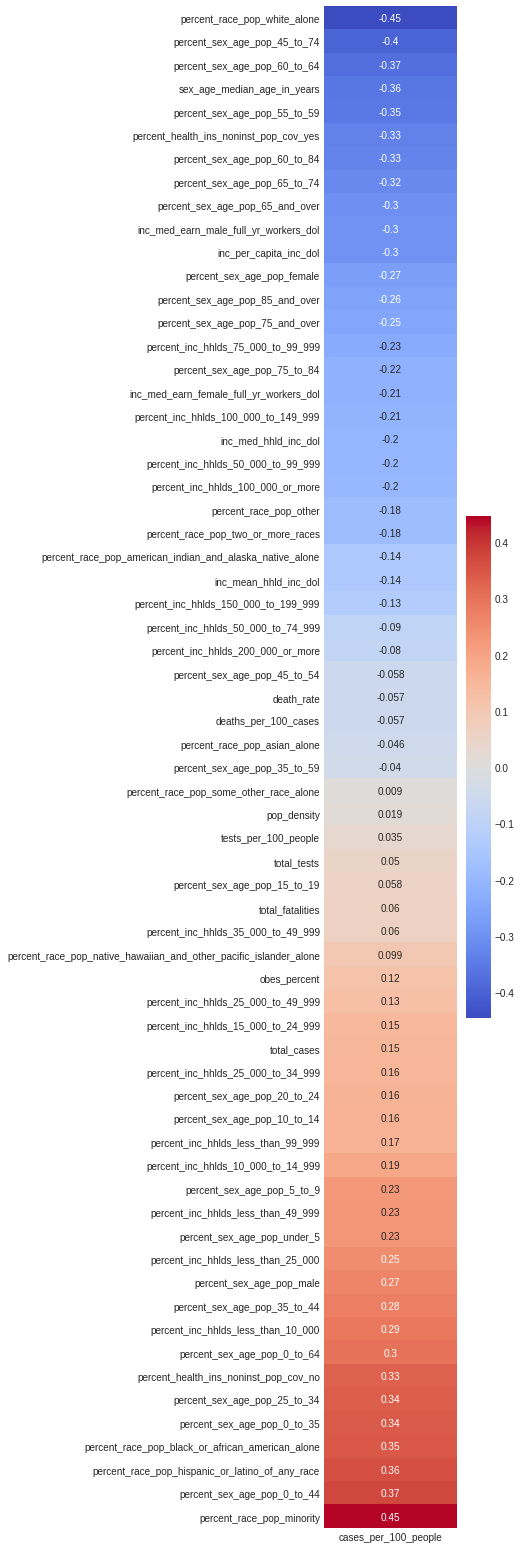

In [25]:
# Visualize the correlation between the variables and 'cases_per_100_people'.
# Save a correlation table to a variable.
corr = df_percent.corr()

# Display a correlation chart just for Sale Price.
plt.figure(figsize=(3, 28))
sns.heatmap(corr[['cases_per_100_people']].sort_values(by='cases_per_100_people').iloc[:-2], annot=True, cmap = 'coolwarm');

### Correlations for 'covid_severity'

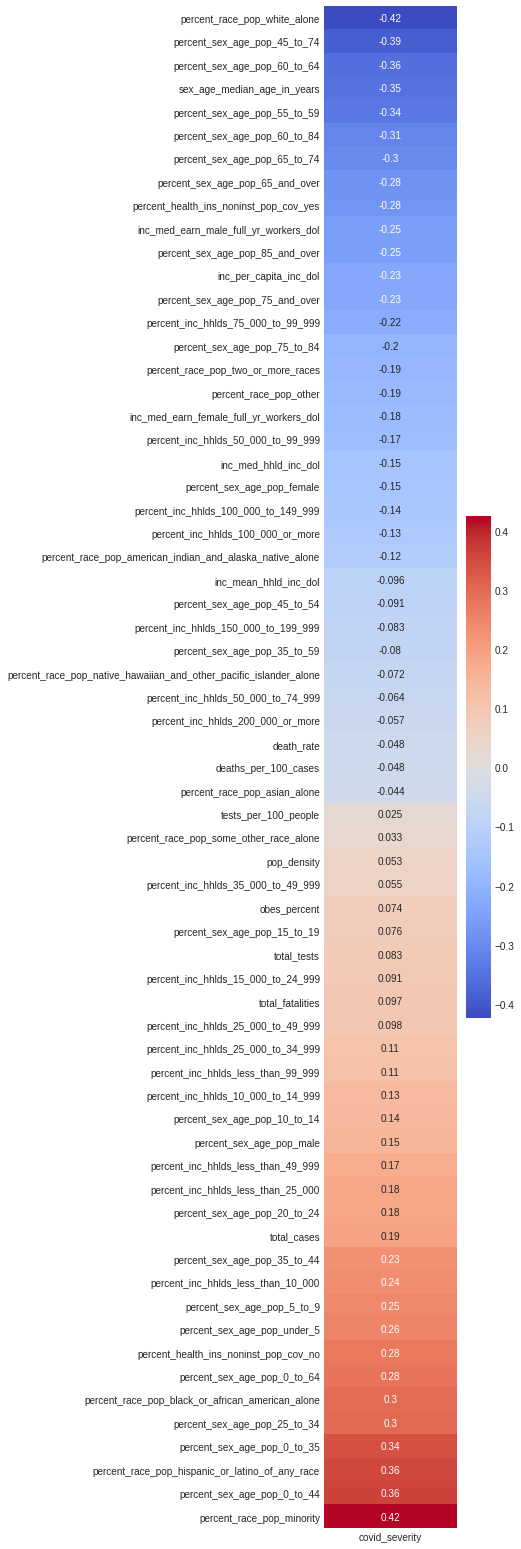

In [26]:
# Visualize the correlation between the variables and 'cases_per_100_people'.
# Save a correlation table to a variable.
corr = df_percent.corr()

# Display a correlation chart just for Sale Price.
plt.figure(figsize=(3, 28))
sns.heatmap(corr[['covid_severity']].sort_values(by='covid_severity').iloc[:-2], annot=True, cmap = 'coolwarm');

## Visualizing Distributions

In [27]:
# Define a custom function to help subplot histograms.
def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, 
                       list_of_ylabels, figsize, bins, ncols, hspace):
    plt.style.use('seaborn-whitegrid')
    nrows = int(np.ceil(len(list_of_columns)/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize) 
    ax = ax.ravel()
    for i, column in enumerate(list_of_columns):
        ax[i].hist(dataframe[column], bins=bins)
        # Set title for each subplot
        ax[i].set_title(list_of_titles[i], fontsize=14)        
        # Set xlabel for each subplot
        ax[i].set_xlabel(list_of_xlabels[i], fontsize=12)
        # Set ylabel for each subplot
        ax[i].set_ylabel(list_of_ylabels[i], fontsize=12)
        plt.subplots_adjust(hspace=hspace);

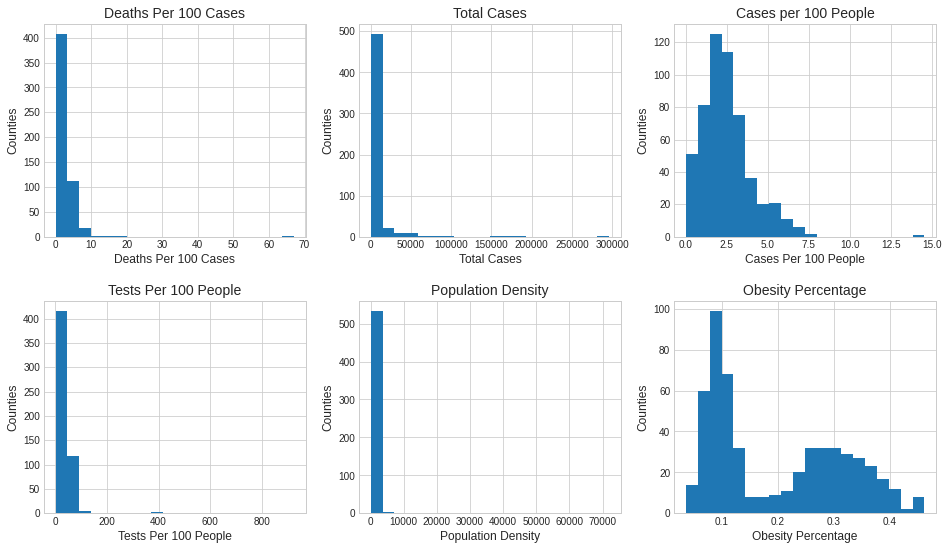

In [28]:
subplot_histograms(
    df,
    ['deaths_per_100_cases', 'total_cases', 'cases_per_100_people', 
     'tests_per_100_people', 'pop_density', 'obes_percent'],
    ['Deaths Per 100 Cases', 'Total Cases', 'Cases per 100 People', 
     'Tests Per 100 People', 'Population Density', 'Obesity Percentage'],
    ['Deaths Per 100 Cases', 'Total Cases', 'Cases Per 100 People', 
     'Tests Per 100 People', 'Population Density', 'Obesity Percentage'],
    ['Counties', 'Counties', 'Counties', 'Counties', 'Counties', 'Counties'],
    figsize=(16,9),
    bins=20,
    ncols=3,
    hspace=.3
)

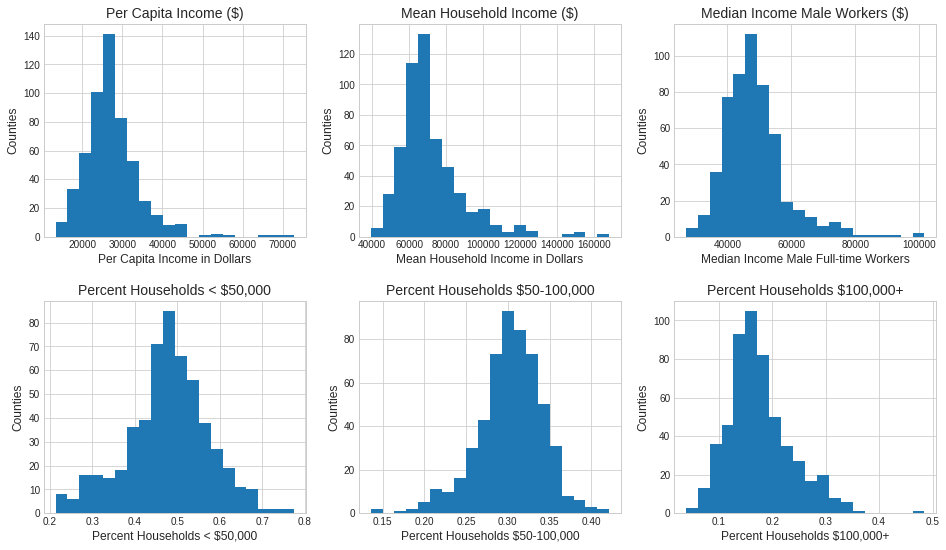

In [29]:
subplot_histograms(
    df,
    ['inc_per_capita_inc_dol', 'inc_mean_hhld_inc_dol', 'inc_med_earn_male_full_yr_workers_dol', 
     'percent_inc_hhlds_less_than_49_999', 'percent_inc_hhlds_50_000_to_99_999', 'percent_inc_hhlds_100_000_or_more'],
    ['Per Capita Income ($)', 'Mean Household Income ($)', 'Median Income Male Workers ($)', 
     'Percent Households < $50,000', 'Percent Households $50-100,000', 'Percent Households $100,000+'],
    ['Per Capita Income in Dollars', 'Mean Household Income in Dollars', 'Median Income Male Full-time Workers', 
     'Percent Households < $50,000', 'Percent Households $50-100,000', 'Percent Households $100,000+'],
    ['Counties', 'Counties', 'Counties', 'Counties', 'Counties', 'Counties'],
    figsize=(16,9),
    bins=20,
    ncols=3,
    hspace=.3
)

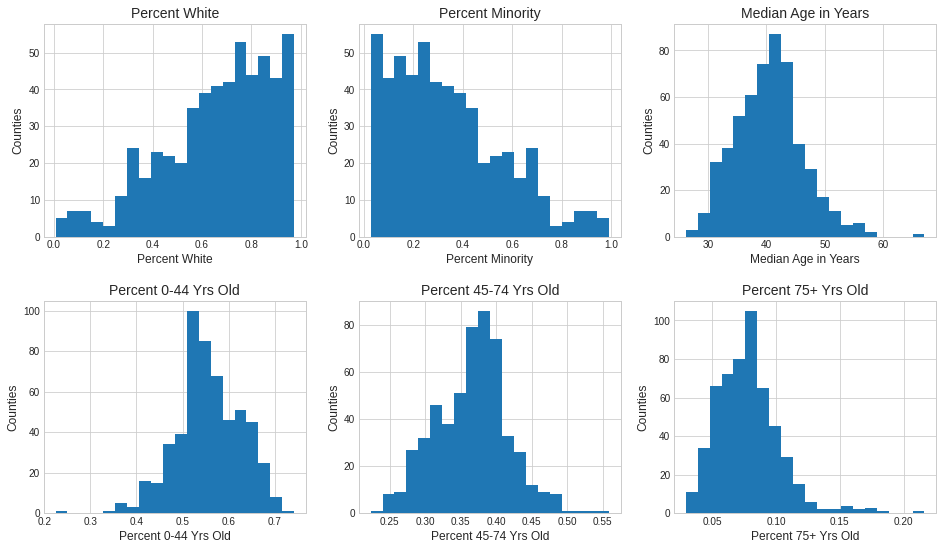

In [30]:
subplot_histograms(
    df,
    ['percent_race_pop_white_alone', 'percent_race_pop_minority', 'sex_age_median_age_in_years', 
     'percent_sex_age_pop_0_to_44', 'percent_sex_age_pop_45_to_74', 'percent_sex_age_pop_75_and_over'],
    ['Percent White', 'Percent Minority', 'Median Age in Years', 'Percent 0-44 Yrs Old', 
     'Percent 45-74 Yrs Old', 'Percent 75+ Yrs Old'],
    ['Percent White', 'Percent Minority', 'Median Age in Years', 'Percent 0-44 Yrs Old',
     'Percent 45-74 Yrs Old', 'Percent 75+ Yrs Old'],
    ['Counties', 'Counties', 'Counties', 'Counties', 'Counties', 'Counties'],
    figsize=(16,9),
    bins=20,
    ncols=3,
    hspace=.3
)

## Plotting variables against 'cases_per_100_people'

In [31]:
# Define a function to help subplot scatterplots.
def subplot_scatter(dataframe, list_of_xcolumns, list_of_ycolumns, list_of_titles, 
                    list_of_xlabels, list_of_ylabels, figsize, s, ncols, hspace):
    plt.style.use('seaborn-whitegrid')
    nrows = int(np.ceil(len(list_of_xcolumns)/ncols)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize) 
    ax = ax.ravel() 
    for i, xcolumn in enumerate(list_of_xcolumns): 
        ax[i].scatter(dataframe[xcolumn], dataframe[list_of_ycolumns[i]], s=s)
        # Set title for each subplot
        ax[i].set_title(list_of_titles[i], fontsize=14)
        # Set xlabel for each subplot
        ax[i].set_xlabel(list_of_xlabels[i], fontsize=12)
        # Set ylabel for each subplot
        ax[i].set_ylabel(list_of_ylabels[i], fontsize=12)
        plt.subplots_adjust(hspace=hspace);

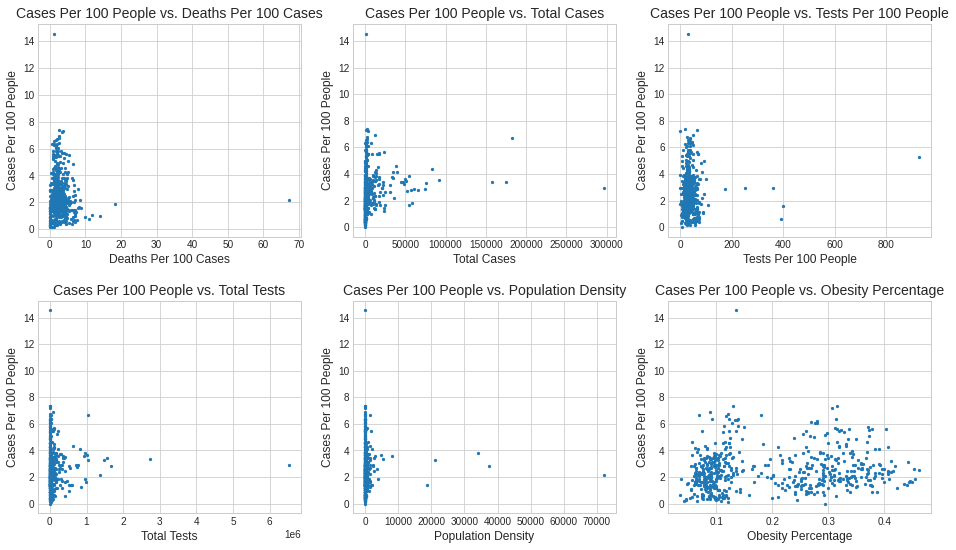

In [32]:
# Plot features of interest against cases_per_100_people.
subplot_scatter(
    df,
    list_of_xcolumns=[
        'deaths_per_100_cases', 'total_cases', 'tests_per_100_people', 
        'total_tests', 'pop_density', 'obes_percent'],
    list_of_ycolumns=[
        'cases_per_100_people', 'cases_per_100_people', 'cases_per_100_people', 
        'cases_per_100_people', 'cases_per_100_people', 'cases_per_100_people'],
    list_of_titles=[
        'Cases Per 100 People vs. Deaths Per 100 Cases',
        'Cases Per 100 People vs. Total Cases',
        'Cases Per 100 People vs. Tests Per 100 People',
        'Cases Per 100 People vs. Total Tests',
        'Cases Per 100 People vs. Population Density',
        'Cases Per 100 People vs. Obesity Percentage'],
    list_of_xlabels=[
        'Deaths Per 100 Cases', 'Total Cases', 'Tests Per 100 People',
        'Total Tests', 'Population Density', 'Obesity Percentage'],
    list_of_ylabels=[
        'Cases Per 100 People', 'Cases Per 100 People', 'Cases Per 100 People',
        'Cases Per 100 People', 'Cases Per 100 People', 'Cases Per 100 People'],
    figsize=(16,9), s=5, ncols=3, hspace=.3)

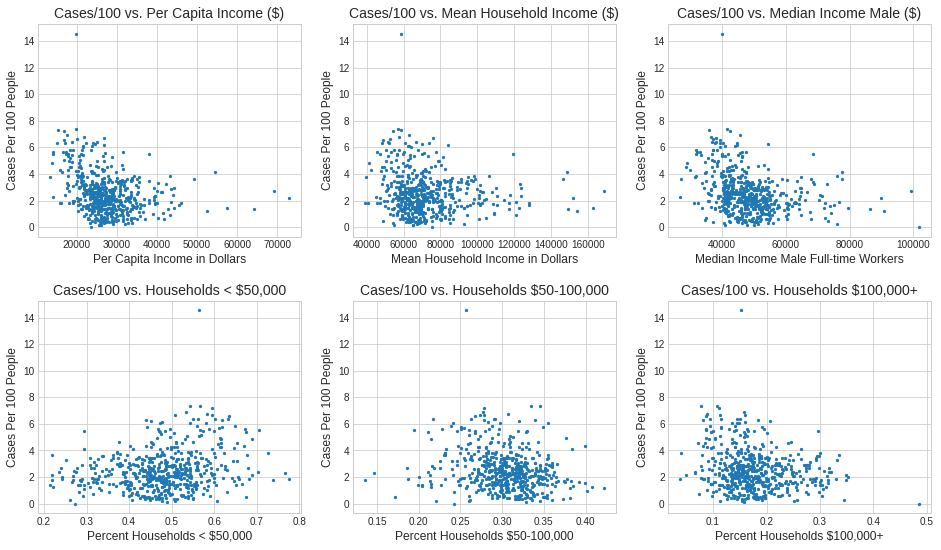

In [33]:
# Plot features of interest against cases_per_100_people.
subplot_scatter(
    df,
    list_of_xcolumns=[
        'inc_per_capita_inc_dol', 'inc_mean_hhld_inc_dol', 'inc_med_earn_male_full_yr_workers_dol', 
        'percent_inc_hhlds_less_than_49_999', 'percent_inc_hhlds_50_000_to_99_999', 'percent_inc_hhlds_100_000_or_more'],
    list_of_ycolumns=[
        'cases_per_100_people', 'cases_per_100_people', 'cases_per_100_people', 
        'cases_per_100_people', 'cases_per_100_people', 'cases_per_100_people'],
    list_of_titles=[
        'Cases/100 vs. Per Capita Income ($)', 'Cases/100 vs. Mean Household Income ($)',
        'Cases/100 vs. Median Income Male ($)', 'Cases/100 vs. Households < $50,000',
        'Cases/100 vs. Households $50-100,000', 'Cases/100 vs. Households $100,000+'],
    list_of_xlabels=[
        'Per Capita Income in Dollars', 'Mean Household Income in Dollars', 'Median Income Male Full-time Workers', 
        'Percent Households < $50,000', 'Percent Households $50-100,000', 'Percent Households $100,000+'],
    list_of_ylabels=[
        'Cases Per 100 People', 'Cases Per 100 People', 'Cases Per 100 People',
        'Cases Per 100 People', 'Cases Per 100 People', 'Cases Per 100 People'],
    figsize=(16,9), s=5, ncols=3, hspace=.3)

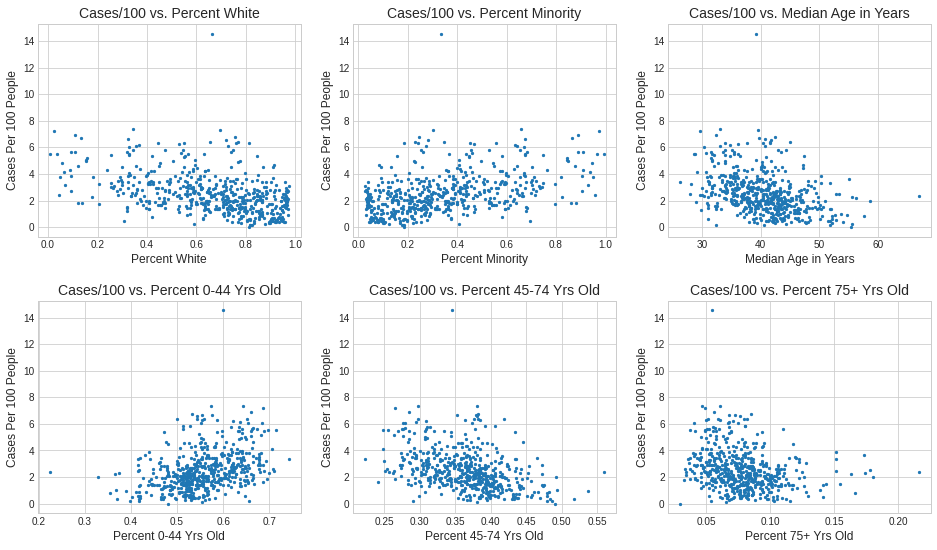

In [34]:
# Plot features of interest against cases_per_100_people.
subplot_scatter(
    df,
    list_of_xcolumns=[
        'percent_race_pop_white_alone', 'percent_race_pop_minority', 'sex_age_median_age_in_years', 
        'percent_sex_age_pop_0_to_44', 'percent_sex_age_pop_45_to_74', 'percent_sex_age_pop_75_and_over'],
    list_of_ycolumns=[
        'cases_per_100_people', 'cases_per_100_people', 'cases_per_100_people', 
        'cases_per_100_people', 'cases_per_100_people', 'cases_per_100_people'],
    list_of_titles=[
        'Cases/100 vs. Percent White', 'Cases/100 vs. Percent Minority',
        'Cases/100 vs. Median Age in Years', 'Cases/100 vs. Percent 0-44 Yrs Old',
        'Cases/100 vs. Percent 45-74 Yrs Old', 'Cases/100 vs. Percent 75+ Yrs Old'],
    list_of_xlabels=[
        'Percent White', 'Percent Minority', 'Median Age in Years', 
        'Percent 0-44 Yrs Old', 'Percent 45-74 Yrs Old', 'Percent 75+ Yrs Old'],
    list_of_ylabels=[
        'Cases Per 100 People', 'Cases Per 100 People', 'Cases Per 100 People',
        'Cases Per 100 People', 'Cases Per 100 People', 'Cases Per 100 People'],
    figsize=(16,9), s=5, ncols=3, hspace=.3)

## Visualizing Cases Per 100 People

### Highest 'cases_per_100_people' Counties

In [35]:
# Extract the 10 counties with the highest cases_per_100_people.
top_10_per = df.sort_values(by='cases_per_100_people', ascending=False)[:10]

In [36]:
colors = {'California':'xkcd:yellowish','Florida':'xkcd:dusty green', 
          'Illinois':'xkcd:melon', 'New York':'xkcd:light grey blue', 'Texas':'xkcd:amber'}

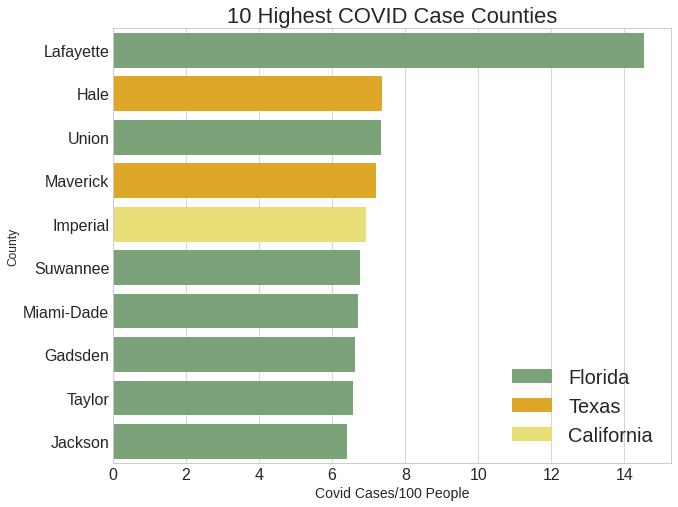

In [73]:
# Plot the 10 counties with the lowest cases_per_100_people by state.
plt.figure(figsize=(10, 8))
g = sns.barplot(x='cases_per_100_people', y='county', hue='state', data=top_10_per, dodge=False, palette=colors)
g.legend(loc='lower right', fontsize=20)
plt.xlabel('Covid Cases/100 People', fontsize=14)
plt.ylabel('County', fontsize=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('10 Highest COVID Case Counties', fontsize=22);

### Lowest 'cases_per_100_people' Counties

In [38]:
# Extract the 10 counties with the lowest cases_per_100_people.
bot_10_per = df.sort_values(by='cases_per_100_people', ascending=True)[1:11]

In [39]:
# Sort the bottom 20 counties in descending order.
bot_10_per = bot_10_per.sort_values(by='cases_per_100_people', ascending=False)

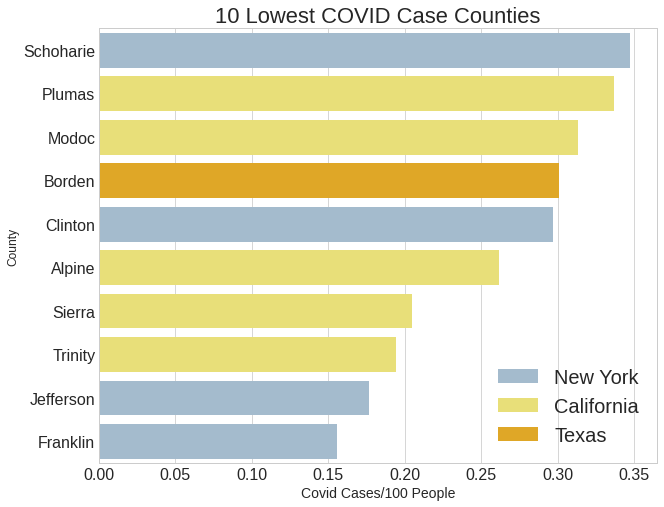

In [94]:
# Plot the 10 counties with the lowest cases_per_100_people by state.
plt.figure(figsize=(10, 8))
g = sns.barplot(x='cases_per_100_people', y='county', hue='state', data=bot_10_per, dodge=False, palette = colors)
g.legend(loc='lower right', fontsize=20)
plt.xlabel('Covid Cases/100 People', fontsize=14)
plt.ylabel('County', fontsize=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('10 Lowest COVID Case Counties', fontsize=22);

# Side by Side

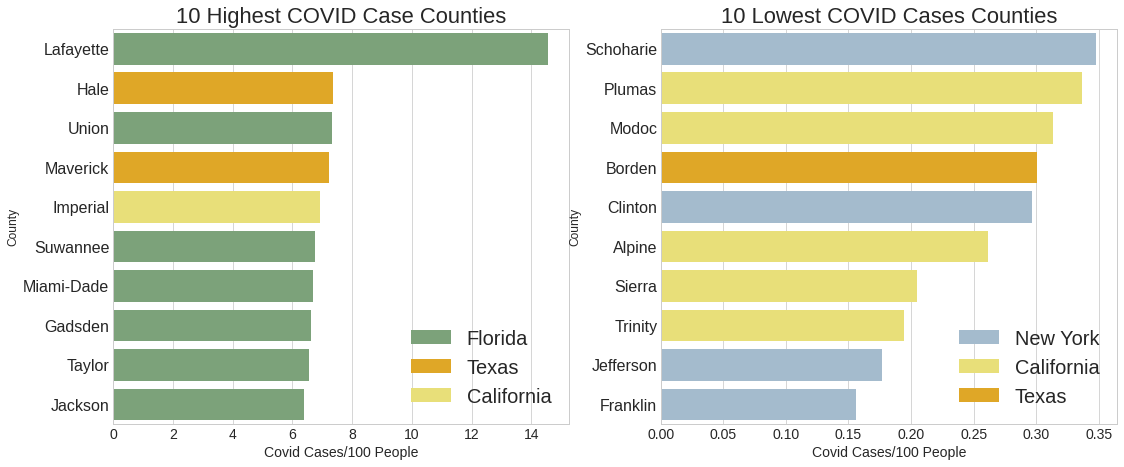

In [87]:
# Plot the 10 counties with the highest cases_per_100_people by state.

# Plot the 
plt.figure(figsize=(18,16))

plt.subplot(2, 2, 1)
g = sns.barplot(x='cases_per_100_people', y='county', hue='state', data=top_10_per, dodge=False, palette=colors)
g.legend(loc='lower right', fontsize=20)
plt.xlabel('Covid Cases/100 People', fontsize=14)
plt.ylabel('County', fontsize=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
plt.title('10 Highest COVID Case Counties', fontsize=22);

plt.subplot(2, 2, 2)
g = sns.barplot(x='cases_per_100_people', y='county', hue='state', data=bot_10_per, dodge=False, palette = colors)
g.legend(loc='lower right', fontsize=20)
plt.xlabel('Covid Cases/100 People', fontsize=14)
plt.ylabel('County', fontsize=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=14)
plt.title('10 Lowest COVID Cases Counties', fontsize=22);

## Visualizing Cases

### Highest COVID Case Counties

In [42]:
# Extract the 10 counties with the highest cases.
top_10_cas = df.sort_values(by='total_cases', ascending=False)[:10]

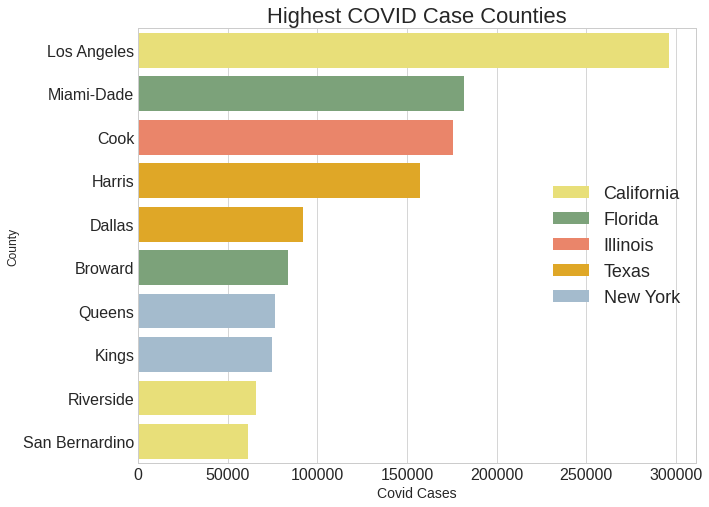

In [79]:
# Plot the 10 counties with the highest cases by state.
plt.figure(figsize=(10, 8))
g = sns.barplot(x='total_cases', y='county', hue='state', data=top_10_cas, dodge=False, palette=colors)
g.legend(loc='center right', fontsize=18)
plt.xlabel('Covid Cases', fontsize=14)
plt.ylabel('County', fontsize=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Highest COVID Case Counties', fontsize=22);

### Lowest COVID Case Counties

In [44]:
# Extract the 10 counties with the lowest cases.
bot_10_cas = df.sort_values(by='total_cases', ascending=True)[1:11]

In [91]:
# ESort the dataframe.
bot_10_cas = bot_10_cas.sort_values(by='total_cases', ascending=False)

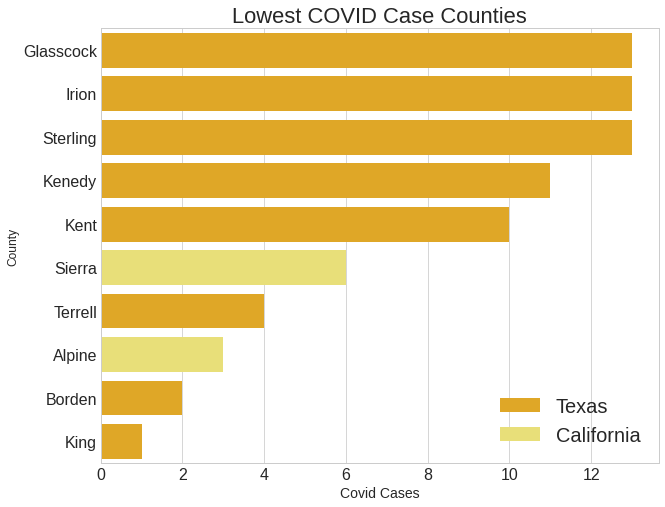

In [93]:
# Plot the 10 counties with the lowest cases by state.
plt.figure(figsize=(10, 8))
g = sns.barplot(x='total_cases', y='county', hue='state', data=bot_10_cas, dodge=False, palette=colors)
g.legend(loc='lower right', fontsize=20)
plt.xlabel('Covid Cases', fontsize=14)
plt.ylabel('County', fontsize=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Lowest COVID Case Counties', fontsize=22);

## Visualizing Death Rate

### Highest Death Rate Counties

In [46]:
# Extract the 10 counties with the highest death rate.
top_10_dea = df.sort_values(by='death_rate', ascending=False)[:10]

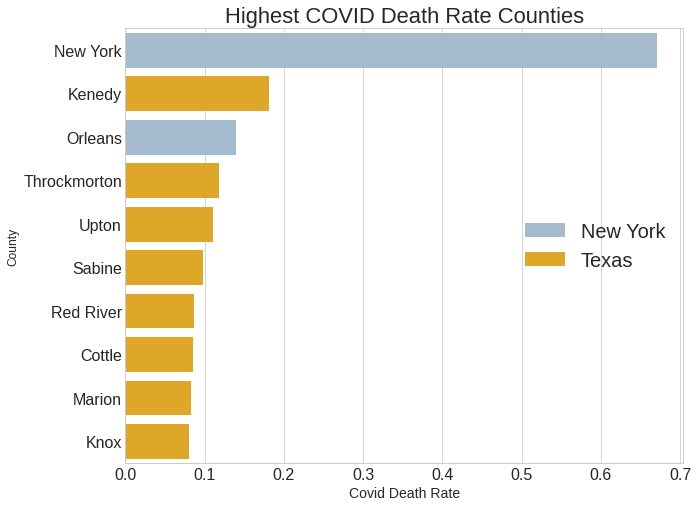

In [90]:
# Plot the 10 counties with the highest death rate by state.
plt.figure(figsize=(10, 8))
g = sns.barplot(x='death_rate', y='county', hue='state', data=top_10_dea, dodge=False, palette=colors)
g.legend(loc='center right', fontsize=20)
plt.xlabel('Covid Death Rate', fontsize=14)
plt.ylabel('County', fontsize=12)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('Highest COVID Death Rate Counties', fontsize=22);

## Comparing High and Low COVID Counties

In [48]:
# Extract the 20 counties with the highest cases_per_100_people.
top_20_per = df.sort_values(by='cases_per_100_people', ascending=False)[:20]

In [49]:
# Extract the 20 counties with the highest cases_per_100_people.
low_20_per = df.sort_values(by='cases_per_100_people', ascending=True)[:20]

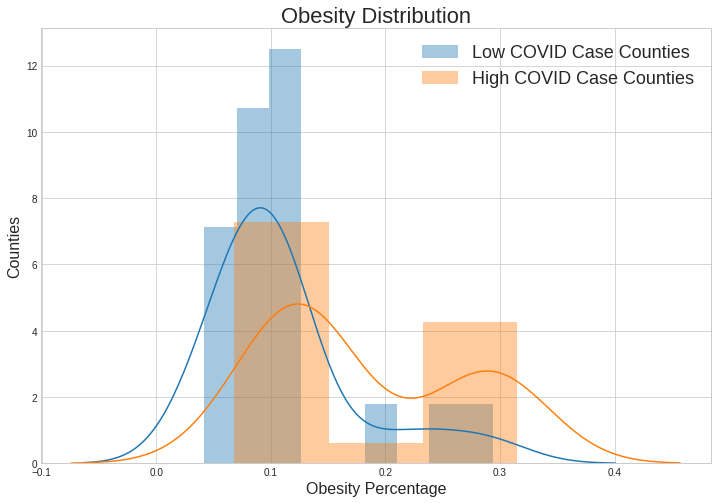

In [55]:
plt.figure(figsize=(12,8))
plt.title('Obesity Distribution', fontsize=22)
sns.distplot(low_20_per['obes_percent'], label='Low COVID Case Counties')
sns.distplot(top_20_per['obes_percent'], label='High COVID Case Counties')
plt.xlabel('Obesity Percentage', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

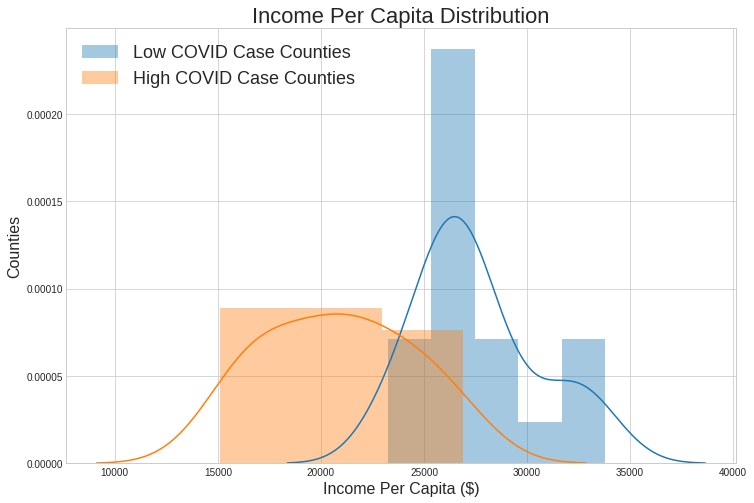

In [54]:
plt.figure(figsize=(12,8))
plt.title('Income Per Capita Distribution', fontsize=22)
sns.distplot(low_20_per['inc_per_capita_inc_dol'], label='Low COVID Case Counties')
sns.distplot(top_20_per['inc_per_capita_inc_dol'], label='High COVID Case Counties')
plt.xlabel('Income Per Capita ($)', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

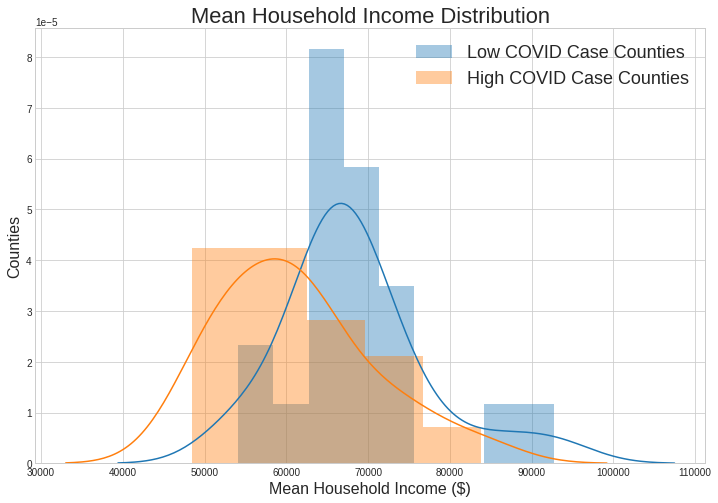

In [57]:
plt.figure(figsize=(12,8))
plt.title('Mean Household Income Distribution', fontsize=22)
sns.distplot(low_20_per['inc_mean_hhld_inc_dol'], label='Low COVID Case Counties')
sns.distplot(top_20_per['inc_mean_hhld_inc_dol'], label='High COVID Case Counties')
plt.xlabel('Mean Household Income ($)', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

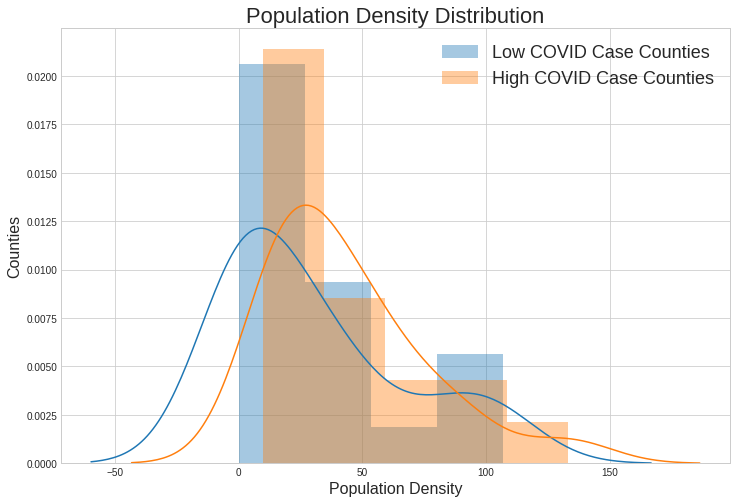

In [58]:
# Drops outlier population density
plt.figure(figsize=(12,8))
plt.title('Population Density Distribution', fontsize=22)
sns.distplot(low_20_per['pop_density'], label='Low COVID Case Counties')
sns.distplot(top_20_per[top_20_per['pop_density'] < 1400]['pop_density'], label='High COVID Case Counties')
plt.xlabel('Population Density', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

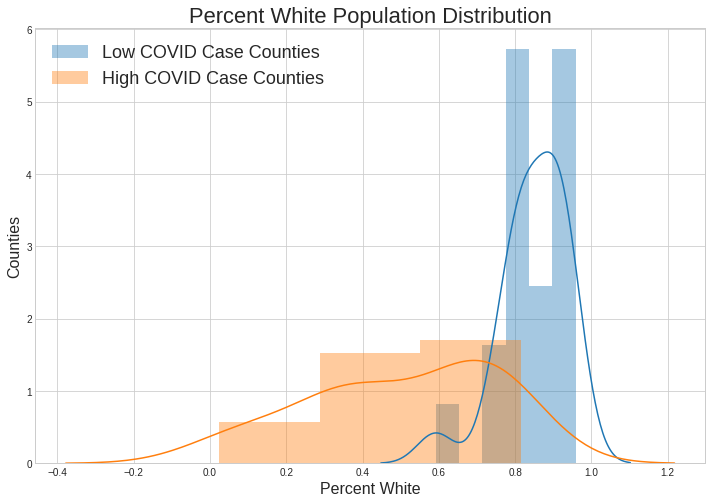

In [59]:
plt.figure(figsize=(12,8))
plt.title('Percent White Population Distribution', fontsize=22)
sns.distplot(low_20_per['percent_race_pop_white_alone'], label='Low COVID Case Counties')
sns.distplot(top_20_per['percent_race_pop_white_alone'], label='High COVID Case Counties')
plt.xlabel('Percent White', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

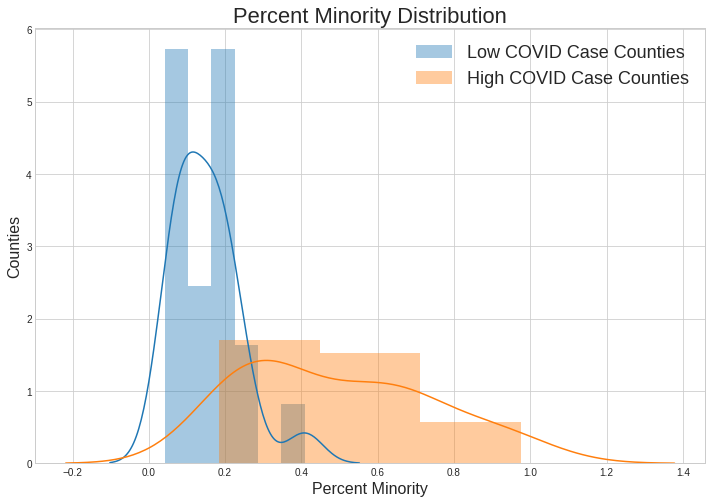

In [60]:
plt.figure(figsize=(12,8))
plt.title('Percent Minority Distribution', fontsize=22)
sns.distplot(low_20_per['percent_race_pop_minority'], label='Low COVID Case Counties')
sns.distplot(top_20_per['percent_race_pop_minority'], label='High COVID Case Counties')
plt.xlabel('Percent Minority', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

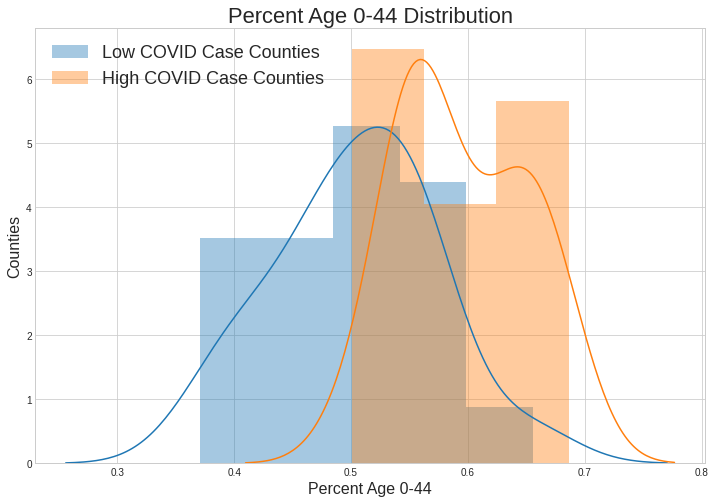

In [61]:
plt.figure(figsize=(12,8))
plt.title('Percent Age 0-44 Distribution', fontsize=22)
sns.distplot(low_20_per['percent_sex_age_pop_0_to_44'], label='Low COVID Case Counties')
sns.distplot(top_20_per['percent_sex_age_pop_0_to_44'], label='High COVID Case Counties')
plt.xlabel('Percent Age 0-44', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

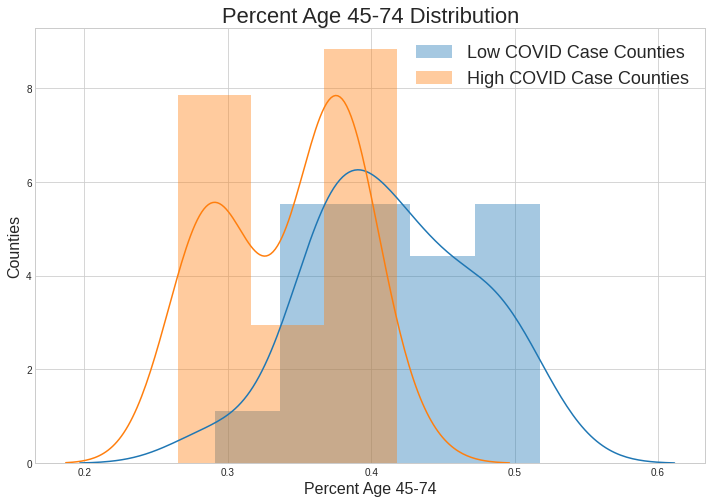

In [62]:
plt.figure(figsize=(12,8))
plt.title('Percent Age 45-74 Distribution', fontsize=22)
sns.distplot(low_20_per['percent_sex_age_pop_45_to_74'], label='Low COVID Case Counties')
sns.distplot(top_20_per['percent_sex_age_pop_45_to_74'], label='High COVID Case Counties')
plt.xlabel('Percent Age 45-74', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

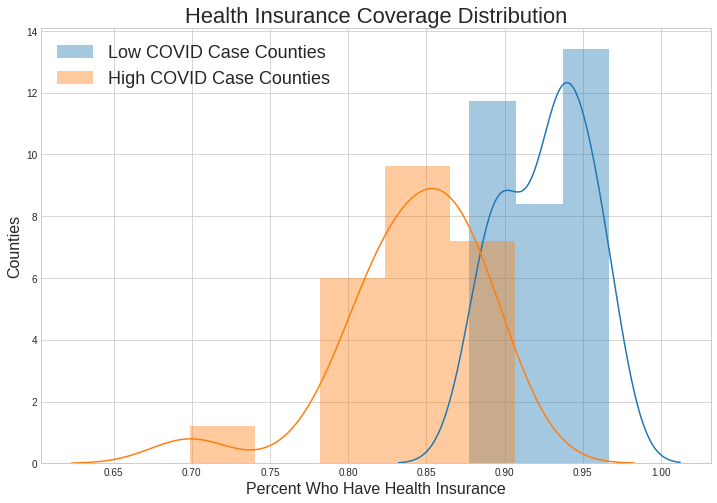

In [63]:
plt.figure(figsize=(12,8))
plt.title('Health Insurance Coverage Distribution', fontsize=22)
sns.distplot(low_20_per['percent_health_ins_noninst_pop_cov_yes'], label='Low COVID Case Counties')
sns.distplot(top_20_per['percent_health_ins_noninst_pop_cov_yes'], label='High COVID Case Counties')
plt.xlabel('Percent Who Have Health Insurance', fontsize=16)
plt.ylabel('Counties', fontsize=16)
plt.legend(fontsize=18);

# Break Out the States

In [46]:
# Create a state-specific dataframe.
df_ca = df[df['county_state'].str.contains('California')]

In [47]:
# Create a state-specific dataframe.
df_fl = df[df['county_state'].str.contains('Florida')]

In [48]:
# Create a state-specific dataframe.
df_il = df[df['county_state'].str.contains('Illinois')]

In [49]:
# Create a state-specific dataframe.
df_ny = df[df['county_state'].str.contains('New York')]

In [50]:
# Create a state-specific dataframe.
df_tx = df[df['county_state'].str.contains('Texas')]

# Export Data for Modeling

In [51]:
# Export the dataframe to a csv.
df.to_csv('../data/cleaned_engineered_five_states.csv', index=False)

In [52]:
# Export the dataframe to a csv.
df_ca.to_csv('../data/cleaned_engineered_ca.csv', index=False)

In [53]:
# Export the dataframe to a csv.
df_fl.to_csv('../data/cleaned_engineered_fl.csv', index=False)

In [54]:
# Export the dataframe to a csv.
df_il.to_csv('../data/cleaned_engineered_il.csv', index=False)

In [55]:
# Export the dataframe to a csv.
df_ny.to_csv('../data/cleaned_engineered_ny.csv', index=False)

In [56]:
# Export the dataframe to a csv.
df_tx.to_csv('../data/cleaned_engineered_tx.csv', index=False)